# 2. Introduction to Brian

You may have noticed that even for a simple LIF neuron with one input synapse, things can get pretty complicated and details matter a lot. It's also not easy to write efficient code that will scale well with the number of neurons in a network.

Luckily, the neuroscience community has some talented software engineers who built simulators to make our lives easier. Unless you want to invest some years into building (and maintaining) your own simulator, it's a good idea to go for a simulator. Especially for spiking networks.

The most popular one for simulation of point neurons in a network is:

![Brian](https://briansimulator.org/logos/brian_logo_big.webp)

Brian (well Brian2 actually) is a free, open-source simulator for spiking networks. It's written in Python and runs a lot of code directly in C, which makes it a lot faster than your custom Python code. All of this magic happens in the background, so you can stay within your comfy Python environment.

In [ ]:
# @title Installation & import of Brian (2)
!pip install brian2
from brian2 import * # import everything from Brian2
                     # (helps to not import every function or class separately)

In [3]:
# @title Other imports
import numpy as np
import matplotlib.pyplot as plt

That's it, now we have Brian2! So let's learn how it works.

## 2.1 Brian has units

No more getting your units confused, because Brian will simply not let you. It has an internal understanding of units and will require you to use them properly. Lets look at a few examples:

In [5]:
# We will define a few parameters in Brian units.
# Above we imported everything from Brian2, allowing us to use the units just
# like that.

E = -75*mvolt
g = 10*nS
I = 100*pamp

# Now see what happens when you divide I_ext by g_L (cf our LIF equation above)
print(I/g)

10. mV


Amazing, right? Brian2 can even convert between units and get the magnitudes right, too!

Feel free to play around a little bit.

In [ ]:
# Here's an example, but you can try any units you want.
print(100*mvolt + 1*volt)

1.1 V


In [ ]:
# What happens when we try to add two inconsistent units like ampere and volt?
E + I

## 2.2 Brian understands math

The second amazing thing about Brian2 is that it's really quite easy to map equations to code for Brian2. In fact, you actually supply your equations as a string!

Let's dig out our LIF neuron equations again:

$$ \tau_m \frac{dV}{dt} = -(V-E_L) + \frac{I}{g_L} $$

In [ ]:
# First we define some of our parameters
tau_m =  20. * ms
E_L =   -75. * mvolt
g_L =    10. * nS
I   =   100. * pA  # we will provide constant external input to our LIF neuron

# Then we type up our LIF equation as string, including the unit
LIF_eq = '''
         dv/dt = (-(v-E_L) + I/g_L)/tau_m : volt
         '''

Now we have everything ready to create a LIF neuron in Brian:

In [ ]:
start_scope() # ignore this for now

# The LIF equation is provided to the Brian2 object 'NeuronGroup'
LIFNeuron = NeuronGroup(1, LIF_eq) # we are creating a group with 1 neuron

# And now we can already run our neuron
run(100*ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.99s). [brian2.stateupdaters.base.method_choice]


That's it already! You just simulated your first neuron in Brian2! 🥳

All the magic is hidden in `NeuronGroup` and `run`, but the cool thing is that you don't really need to worry what's happening inside as long as you provide the right input arguments and know how to use the output.

Speaking of output, we can check what's the state of the membrane potential at the end of the simulation by accessing the `v` attribut from the NeuronGroup `LIFNeuron`.

In [ ]:
print(LIFNeuron.v[0]) # we need to access value 0, because by default NeuronGroup creates an array of neurons (here length 1)

-64.56203345 mV


So far so good.

What we're still missing is:

* a spiking mechanism (threshold, reset, refractory period)
* some way to track the membrane potential and save spikes

## 2.3 How to add spikes and record variables

In [ ]:
start_scope()

# parameters for the spiking mechanism
V_th =    -55. * mV
V_reset = -75. * mV
tau_ref =   2. * ms

# we will also ramp up I a bit
I = 300. * pamp

# we need to make a minor edit of our LIF equations
LIF_eq = '''
         dv/dt = (-(v-E_L) + I/g_L)/tau_m : volt (unless refractory)
         '''
# this prevents v to change while in refractory period

# the NeuronGroup has arguments for spiking threshold, reset and refractory period
# we can also add the numerical integration method
LIFNeuron = NeuronGroup(1, LIF_eq, threshold='v>V_th', reset='v = V_reset',
                        refractory=tau_ref, method='exact')

# we can set the initial value of the membrane potential
LIFNeuron.v = E_L

# to record variables, we can use the StateMonitor, here we record v
statemon = StateMonitor(LIFNeuron, 'v', record=True)
# Note: `record` can also be an integer or a list to specify which neurons
#       to record from

# spikes can be tracked with the SpikeMonitor
spikemon = SpikeMonitor(LIFNeuron)

# let's run again!
run(100*ms)

Now we can plot the stuff we saved.

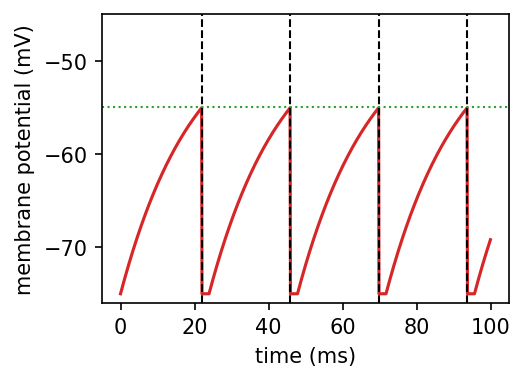

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=150)
ax.plot(statemon.t/ms, statemon.v[0]*1000, c='C3')
for ti in spikemon.t:
    ax.axvline(ti/ms, ls='--', c='k', lw=1)
axhline(V_th/mV, ls=':', c='C2', lw=1)
ax.set(xlabel='time (ms)', ylabel='membrane potential (mV)', ylim=[-76, -45])
plt.show()

## 2.4 How to make Poisson inputs

In the example above we just provide constant input, but what if we want to generate Poisson spike trains as inputs?

Brian has a class `PoissonGroup` that does exactly that.


In [ ]:
# Choose parameters for Poisson input
N_ext = 1  # number of neurons (i.e. spike trains) of external Poisson input
rate_ext = 10 * Hz  # firing rate of Poisson input neurons

# create the Poisson input group
neurons_ext = PoissonGroup(N_ext, rate_ext)

## 2.5 Creating synapses in Brian

We know how to create neurons and inputs, but we also need synapses to connect them.

Again, there is a class for it! And unsurprisingly, it's called `Synapses`! Sounds simple and that's what it is. You just need to learn how to use the class.

To understand how to build synapses in Brian, we will model one LIF neuron that receives input from one Poisson neuron through a synapse. For now we will us a very simple synapse model, where the voltage just increases by a weight $w$ with every spike.

In [ ]:
start_scope()

# set up equations for a LIF neuron
LIF_eq = '''
         dv/dt = -(v-E_L)/tau_m : volt (unless refractory)
         tau_m : second
         E_L : volt
         '''
# note that we now made tau_m, E_L and g_L parameters of the neuron, we will set
# the values in a bit
# and: units in equations need to be base units, the magnitude is specified later

# create the LIF neuron
LIFNeuron = NeuronGroup(1, LIF_eq, threshold='v>V_th', reset='v = V_reset', refractory=tau_ref,
                method='exact')

# set values of the LIF neuron, they are attributes of the object
LIFNeuron.tau_m = 20 * ms # membrane time constant
LIFNeuron.E_L = -75. * mV # resting membrane potential
LIFNeuron.v = -75. * mV # initial membrane potential

# create the Poisson input neuron
InputNeuron = PoissonGroup(1, 100 * Hz)

# we are ready for synapses!
w = 1 * mV  # for our simple synapse, this will be the weight
syn = Synapses(InputNeuron, LIFNeuron, on_pre='v += w')
syn.connect()

---
🟦 **Exercise 2.1: Write a block of code to run the model, record the spikes of the Poisson input, record the membrane potential of the LIF neuron and plot the results.**

In [ ]:
# set up monitors
# ---------------

# TODO: your code here >>>



# <<<

# run the model for 500 ms
# ------------------------

# TODO: your code here >>>



# <<<

# plotting
# --------
# (spikes from the Poisson input and the membrane potential of the LIF
# neuron into one plot)

# TODO: your code here >>>



# <<<


#### Hints

- you can scroll up to find the right commands
- the model we created above should still be in memory
- plot the spikes of the input neuron using vlines (not axvline)

## 2.6 Putting things together: simulate a neuron with multiple CUBA synapses

We have learned a lot already! Lets put all we've learned about Brian together. To make the postsynaptic LIF neuron spike from the input spikes, we need more presynaptic Poisson neurons. Now we will also implement actual current-based synapses in Brian.

 ---

 🟦 **Exercise 2.2: Simulate a neuron with multiple CUBA synapses.**
 - your neuron should receive input from a population of `N_ext = 50` excitatory Poisson input neurons with firing rate of `r_ext = 15 Hz`
 - the input neurons have current-based synapses onto the LIF neuron (**NOTE**: the simple synapse above is *not* a CUBA synapse)
 - the synaptic strength of all weights to the LIF neuron should be `w = 20 pA`
 - run the network for 1000 ms
 - record the membrane potential of the LIF neuron and plot it
 - record the spike times of the presynaptic population and plot them

**Already done? Here's more things you can do:**

- Play with the firing rate and size of the external input population. What happens when the input is too low?
- Add a population of inhibitory Poisson neurons.
- Play with the firing rate of the inhibitory relative to the excitatory input population.
- Implement COBA synapses instead.


In [ ]:
# YOUR SOLUTION BELOW >>>



#### Hints

- you will need the Brian objects `PoissonGroup` `NeuronGroup`, `Synapses`
- the LIF Neuron needs a few more attributes to implement current-based synapses (e.g. leak conductance and the input current)
- in the equations for Brian objects, you need to specifiy units without their magnitude (i.e. `siemens` instead of `uS` or `ampere` instead of `pA`)
- you can plot the presynaptic input spikes as a scatter plot by accessing the spike times and corresponding neuron IDs from the SpikeMonitor (`spikemon.t` and `spikemon.i`)

#### Notes:
* there's many more way in which we can use the `connect` function to create networks with different types of connectivity
